# Chapter 8 Dimensionality Reduction

When we have many features in our dataset, or a high-dimensional space, we run into the problem of the *curse of dimensionality*. Our data becomes very sparse, making prediction more difficult, and the number of features required to achieve generalizable accuracy grows exponentially with the number of dimensions. Reducing dimensionality is an easier way of dealing with this problem than collecting that much more data, and is also useful for speeding up training, usually but not not necessarily at the cost of model performance. If we are getting rid of noisy or uninformative data, it might actually improve model performance. It can also be useful for visualizing higher-dimensional data for exploratory data analysis.

There are two main approaches to dimensionality reduction: projecting the data into a lower dimensional subspace (projection) or representing the data using manifolds (manifold learning), which are lower-dimensional objects embedded in our given space. Let's look at some specific algorithms.

## PCA

PCA works by projecting our data onto the hyperplane which preserve the most variation in our data, since these new features retain the most information about our original data. This turns out to be equivalent to finding the new features which are closest to the original data, in the sense of having the smallest mean squared error between our projection and the original data.

### Principal Components

These new features that PCA creates are called principal components. PCA will first find the axis which preserves the most variance in the data, then do so again and again with the constraint that the nth axis is orthogonal to the previous (n-1) axes. The unit vector defining the i-th axis is called the i-th principal component. PCA is thus equivalent to finding a new coordinate system to represent our data. We can then reduce our data down to d dimensions by projecting it onto the space formed by our first d principal components.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [13]:
from sklearn.decomposition import PCA

# Generate 3D data
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
print(X.shape)

# Reduce to 2 dimensions
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
print(X2D.shape)

# Look at components
pca.components_

# Look at variance accounted for by each component
print(pca.explained_variance_ratio_)

(60, 3)
(60, 2)
[0.88748121 0.10370744]


### Choosing the Number of Dimensions

Instead of explicitly defining the number of principal components we'd like to create, we can pass in a float between 0 and 1 to n_components which is the ratio of variance we'd like to account for. sklearn will then create however many components are required by itself. We could also plot the number of dimensions vs the "explained" variance, and see where further dimensions start leading to diminishing returns (the crook of the elbow). 

### PCA for Compression

Let's use PCA on the handwritten digits dataset so that our new features account for 95% of the variance in our original dataset.

In [54]:
from sklearn.datasets import load_digits

mnist = load_digits()

X = mnist.data
y = mnist.target

pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X)
print(f'explained variance: {sum(pca.explained_variance_ratio_)}')
print(f'num of original features: {X.shape[1]}')
print(f'num of principal components: {len(X_reduced[0])}')

explained variance: 0.9547965245651595
num of original features: 64
num of principal components: 29


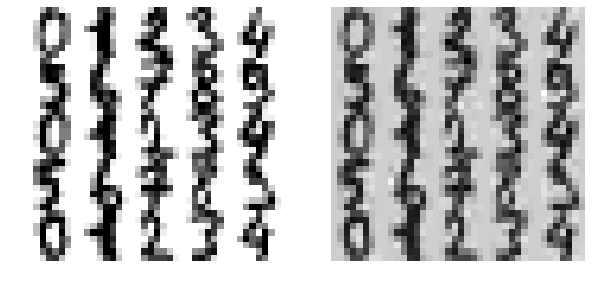

In [61]:
X_recovered = pca.inverse_transform(X_reduced)

def plot_digits(instances, images_per_row=5, **options):
    size = 8
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(10,5))
plt.subplot(121)
plot_digits(X[:25])
plt.subplot(122)
plot_digits(X_recovered[:25])

We can see that most characteristics are preserved, even after reducing the number of dimensions by more than half.

If our data set is too large to fit in memory, we can also use incremental PCA with partial_fit() to train the data in batches, or pass svd_solver='randomized' to perform Randomized PCA which runs in O(m\*d^2) + O(d^3) time rather than O(m\*n^2) + O(n^3), where d is the number of principal components and d is the number of original features. 

### Kernel PCA

If we have non-linear data that lie closely along a manifold, we can sometimes use the kernel trick from SVMs to project this data into a higher dimensional space where it can then be projected onto a ultimately lower dimensional subspace.

#### Selecting a Kernel and Tuning Hyperparameters

Since kPCA is unsupervised, we don't have given metrics for comparing the performance of different hyperparameters. However, since kPCA is usually a form of data processing, so we tune hyperparameters within the context of a pipeline. Let's use logistic regression as our estimator and its associated scoring metric, accuracy, for our grid search. We will use a "Swiss roll" as our dataset.

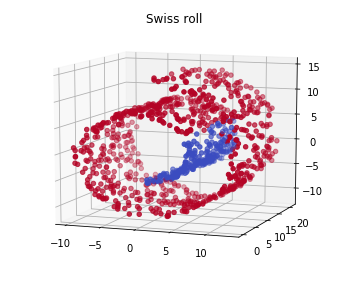

In [115]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
ax.view_init(10, -70)
plt.title('Swiss roll');

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.07, 5),
        "kpca__kernel": ["linear", "rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'kpca__gamma': 0.04, 'kpca__kernel': 'rbf'}


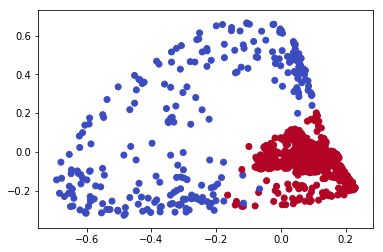

In [120]:
kpca = KernelPCA(n_components=2, gamma=0.05, kernel='rbf')
X_reduced = kpca.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.coolwarm);

We can see that our PCA decomposition does a good job of separating the data. 

## LLE

Locally linear embedding (LLE) tries to find a lower-dimensional representation of our data which preserves the distances between an instance's closest neighbors. Let's use this technique on a Swiss roll.

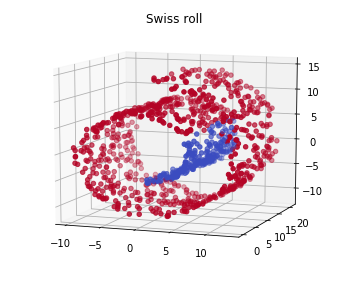

In [121]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
ax.view_init(10, -70)
plt.title('Swiss roll');

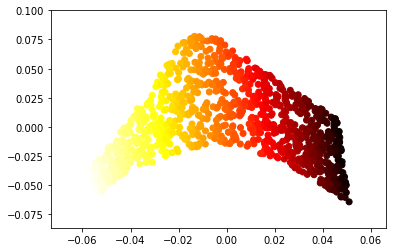

In [123]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=t, cmap=plt.cm.hot);